In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# --- II. Step-by-Step Procedure ---

# A. 1. Business Understanding and Problem Definition
# Goals: Optimize inventory levels based on car sales forecasts.
# Scope: Forecast monthly car sales.
# Stakeholders: Sales manager, inventory planner.
# Success Metrics: Minimize RMSE of monthly sales forecasts.

# B. 2. Data Collection and Exploration

# Data Ingestion
try:
    data = pd.read_csv('monthly-car-sales.csv')
except FileNotFoundError:
    print("Error: monthly-car-sales.csv not found.  Make sure the file is in the same directory as the script, or specify the full path.")
    exit()

# Convert 'Month' to datetime objects, handle parsing errors
try:
    data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
except ValueError as e:
    print(f"Error parsing 'Month' column: {e}. Check the date format in your CSV file.")
    exit()

# Set 'Month' as index
data.set_index('Month', inplace=True)
data.sort_index(inplace=True)

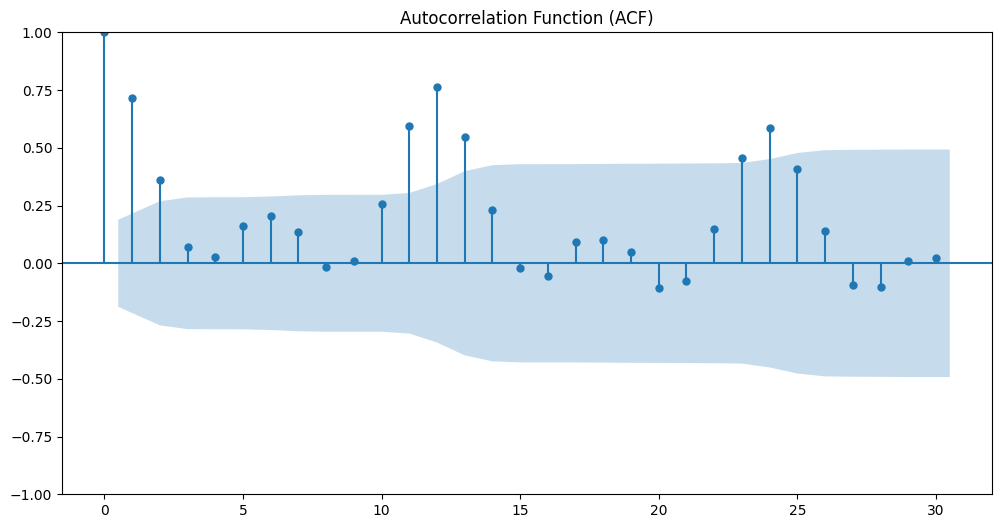

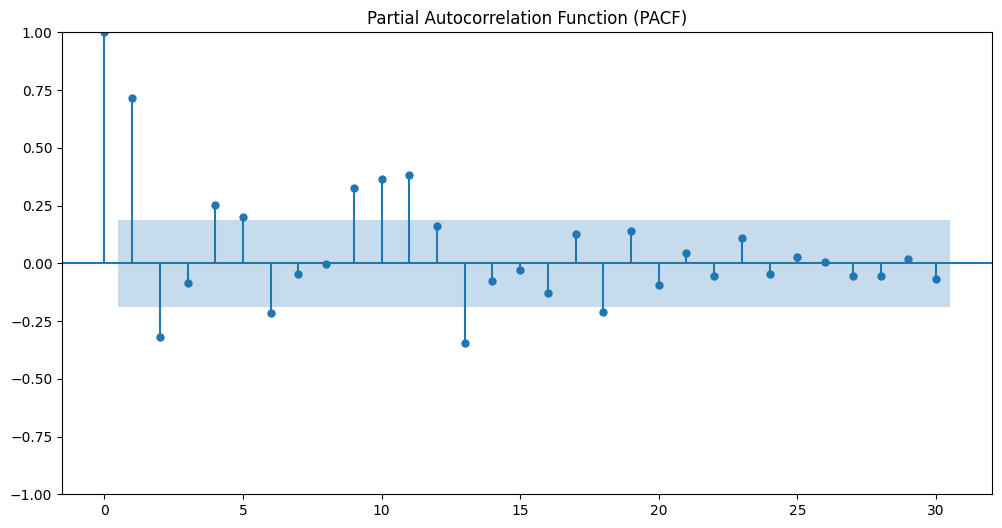

In [14]:
#Add ACF and PACF plots to help identify the order of AR and MA components for potential ARIMA models.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(12, 6))
plot_acf(data['Sales'], lags=30, ax=plt.gca())  # Adjust lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(data['Sales'], lags=30, ax=plt.gca(), method='ywm')  # Adjust lags as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Simple Exp Smoothing MAE: 3636.40, RMSE: 4049.49
Holt's Method MAE: 6566.15, RMSE: 7270.07
Holt-Winters' Method MAE: 1290.92, RMSE: 1820.20


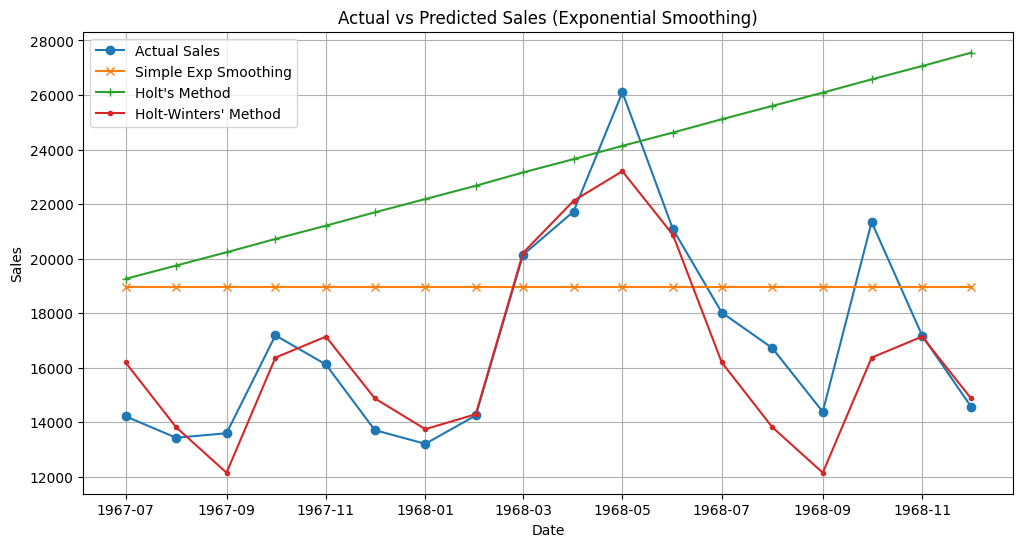

In [15]:
#Exponential Smoothing Models: Implement and evaluate SimpleExpSmoothing, Holt, and HoltWinters models.
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Simple Exponential Smoothing
fit1 = SimpleExpSmoothing(y_train).fit(smoothing_level=0.2, optimized=False)
y_pred_ses = fit1.forecast(len(y_test))

# Holt's Linear Trend Model
fit2 = Holt(y_train).fit(smoothing_level=0.2, smoothing_trend=0.2, optimized=False)
y_pred_holt = fit2.forecast(len(y_test))

# Holt-Winters' Seasonal Method
fit3 = ExponentialSmoothing(y_train, seasonal_periods=12, seasonal='additive').fit()  # Adjust seasonal_periods if needed
y_pred_holt_winters = fit3.forecast(len(y_test))

# Evaluate Exponential Smoothing Models (Calculate MAE, RMSE, etc. for each)
mae_ses = mean_absolute_error(y_test, y_pred_ses)
rmse_ses = np.sqrt(mean_squared_error(y_test, y_pred_ses))
print(f"Simple Exp Smoothing MAE: {mae_ses:.2f}, RMSE: {rmse_ses:.2f}")

mae_holt = mean_absolute_error(y_test, y_pred_holt)
rmse_holt = np.sqrt(mean_squared_error(y_test, y_pred_holt))
print(f"Holt's Method MAE: {mae_holt:.2f}, RMSE: {rmse_holt:.2f}")

mae_hw = mean_absolute_error(y_test, y_pred_holt_winters)
rmse_hw = np.sqrt(mean_squared_error(y_test, y_pred_holt_winters))
print(f"Holt-Winters' Method MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[test_index], y_test, label='Actual Sales', marker='o')
plt.plot(data.index[test_index], y_pred_ses, label='Simple Exp Smoothing', marker='x')
plt.plot(data.index[test_index], y_pred_holt, label='Holt\'s Method', marker='+')
plt.plot(data.index[test_index], y_pred_holt_winters, label='Holt-Winters\' Method', marker='.')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (Exponential Smoothing)')
plt.legend()
plt.grid(True)
plt.show()

Normality Test: Statistic=5.297, p=0.071
Residuals are likely normally distributed


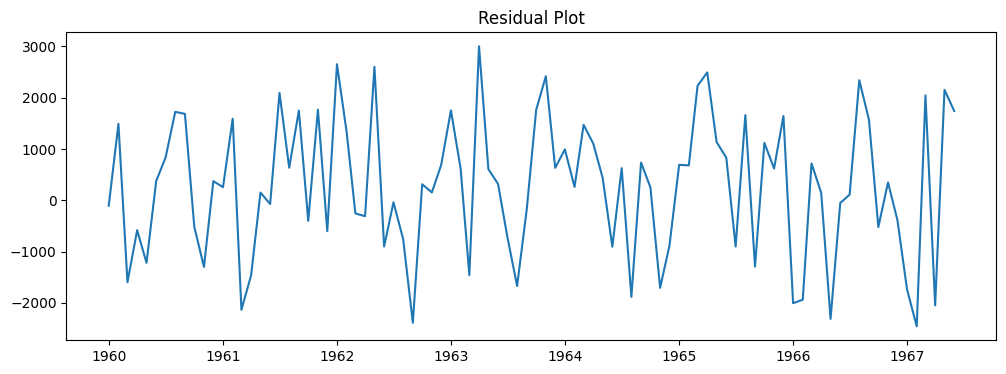

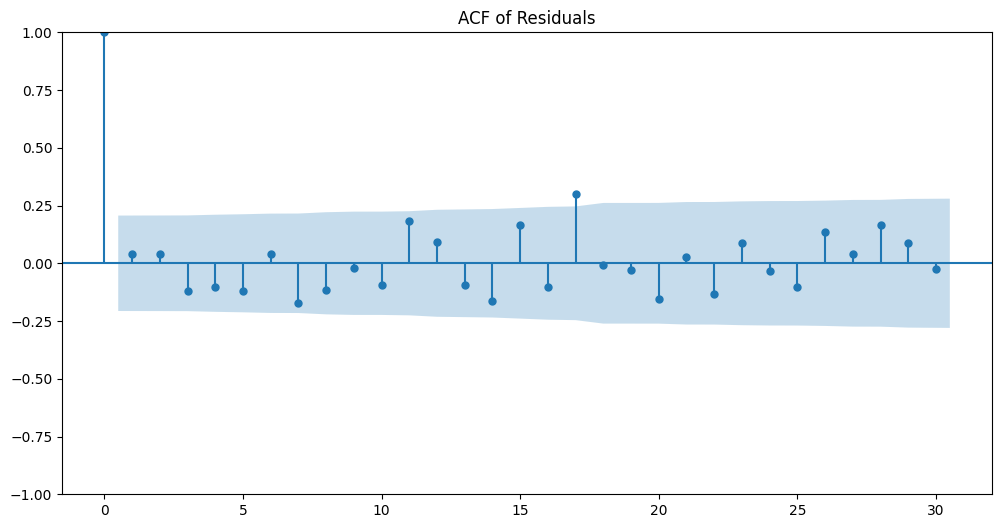

In [17]:
#Checking for Normality and Autocorrelation in Residuals: The notebook analyzes the residuals (the difference between the actual
#and predicted values) to ensure they are normally distributed and have no autocorrelation.
#This is a key step in validating a time series model. If residuals aren't random, it suggests the model is missing something.

from scipy.stats import normaltest
# Assuming 'fit3' is the best Holt-Winters model
residuals = fit3.resid

# Normality Test
stat, p = normaltest(residuals)
print(f"Normality Test: Statistic={stat:.3f}, p={p:.3f}")
if p > 0.05:
    print("Residuals are likely normally distributed")
else:
    print("Residuals are not likely normally distributed")

# Plot Residuals
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Residual Plot')
plt.show()

# ACF plot of residuals (check for autocorrelation)
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=30, ax=plt.gca())
plt.title('ACF of Residuals')
plt.show()

In [13]:
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Example (assuming y_pred_hw is the Holt-Winters forecast)
rmsle_hw = rmsle(y_test, y_pred_holt_winters)
print(f"Holt-Winters RMSLE: {rmsle_hw:.4f}")

Holt-Winters RMSLE: 0.1070



Data Exploration:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 1960-01-01 to 1968-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   108 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB
None
              Sales
count    108.000000
mean   14595.111111
std     4525.213913
min     5568.000000
25%    11391.250000
50%    14076.000000
75%    17595.750000
max    26099.000000

Missing Values:
Sales    0
dtype: int64


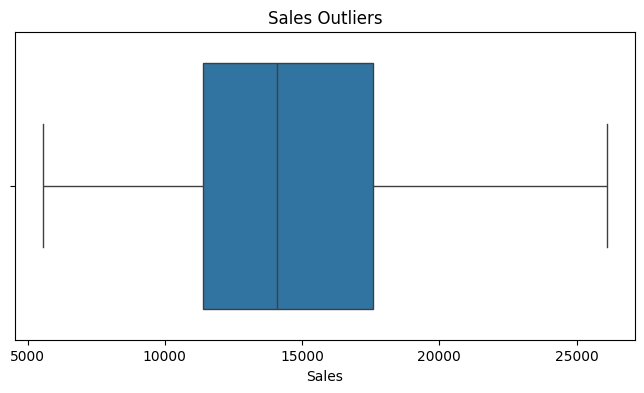

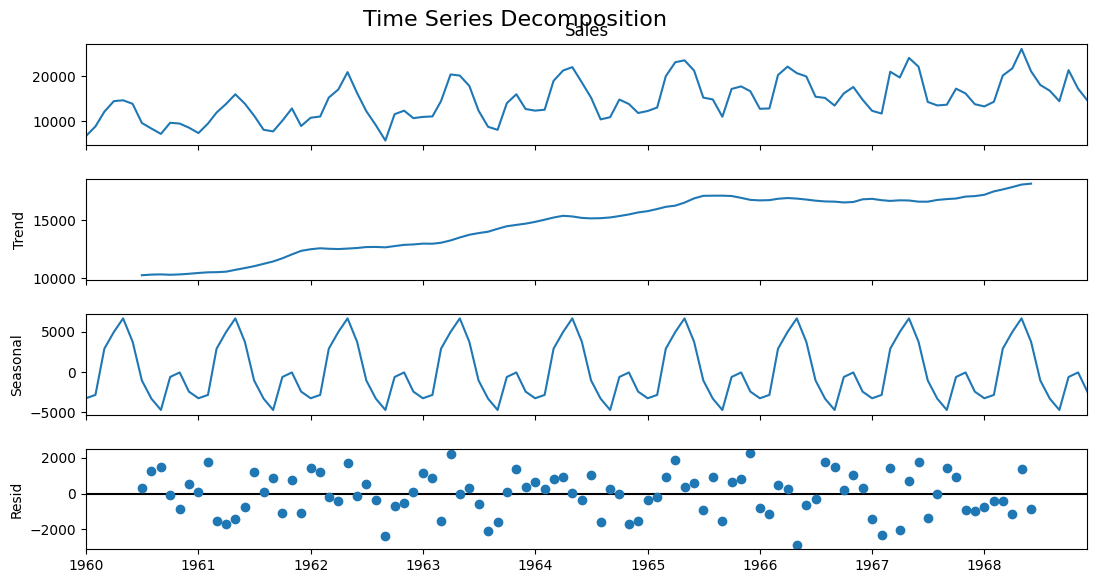


Correlation Matrix:
Sales          1.000000
Sales_Lag_1    0.728068
Sales_Lag_2    0.367645
Name: Sales, dtype: float64


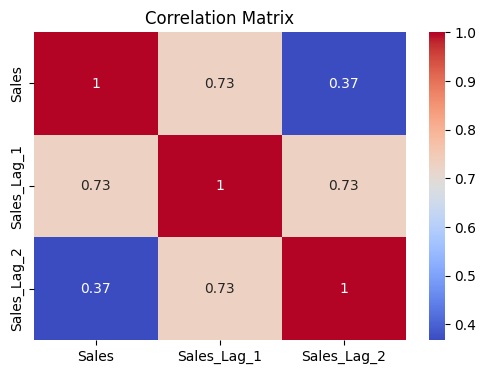

In [3]:
# Data Exploration and Analysis
print("\nData Exploration:")
print(data.info())
print(data.describe())

# Missing Value Analysis
print("\nMissing Values:")
print(data.isnull().sum())  # Check for missing values

# Outlier Detection (Simple example - boxplots)
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['Sales'])
plt.title("Sales Outliers")
plt.show()

# Trend and Seasonality Analysis
# Decompose the time series
decomposition = seasonal_decompose(data['Sales'], model='additive', period=12)  # Monthly data so period=12
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.suptitle("Time Series Decomposition", fontsize=16)
plt.show()

# Correlation Analysis (Simple example)
# Create lag features for correlation analysis (avoiding data leakage)
data['Sales_Lag_1'] = data['Sales'].shift(1)
data['Sales_Lag_2'] = data['Sales'].shift(2)

correlation_matrix = data.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix['Sales'])

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [4]:
# C. 3. Feature Engineering

# Time-Based Features
data['Year'] = data.index.year
data['Month_Num'] = data.index.month  #Numerical representation of the month
data['Quarter'] = data.index.quarter

# Create a cyclical feature for month using sine and cosine transformations
data['Month_sin'] = np.sin(2 * np.pi * data['Month_Num'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month_Num'] / 12)


# Lag Features (Example - 1 and 2 month lag)  Important to be aware of data leakage
#Already added above for correlation analysis
data.fillna(data['Sales'].mean(), inplace=True)  # Handle missing lag values in the first few rows

# Rolling Statistics (Example - 3 month moving average)
data['Sales_Rolling_Mean'] = data['Sales'].rolling(window=3).mean().shift(1).fillna(data['Sales'].mean())  # Shift to avoid data leakage

print("\nFeature Engineered Data:")
print(data.head())


Feature Engineered Data:
            Sales   Sales_Lag_1   Sales_Lag_2  Year  Month_Num  Quarter  \
Month                                                                     
1960-01-01   6550  14595.111111  14595.111111  1960          1        1   
1960-02-01   8728   6550.000000  14595.111111  1960          2        1   
1960-03-01  12026   8728.000000   6550.000000  1960          3        1   
1960-04-01  14395  12026.000000   8728.000000  1960          4        2   
1960-05-01  14587  14395.000000  12026.000000  1960          5        2   

            Month_sin     Month_cos  Sales_Rolling_Mean  
Month                                                    
1960-01-01   0.500000  8.660254e-01        14595.111111  
1960-02-01   0.866025  5.000000e-01        14595.111111  
1960-03-01   1.000000  6.123234e-17        14595.111111  
1960-04-01   0.866025 -5.000000e-01         9101.333333  
1960-05-01   0.500000 -8.660254e-01        11716.333333  


In [5]:
# D. 4. Model Selection and Training

# Model Selection
# Choosing Linear Regression and Random Forest for demonstration
# For real-world scenarios, experiment with ARIMA, Exponential Smoothing, LSTMs, etc.

# Feature selection
features = ['Year', 'Month_sin', 'Month_cos', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Rolling_Mean', 'Quarter']
target = 'Sales'

X = data[features]
y = data[target]

# Train, test split (TimeSeriesSplit for time series data)
# Use TimeSeriesSplit to avoid data leakage and respect temporal order
n_splits = 5  # Adjust as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate through splits and train/evaluate the model for each split
mae_lr_scores = []
rmse_lr_scores = []
mae_rf_scores = []
rmse_rf_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scaling data (fit only on the training data)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test) #Scale the test using fit from train

    # Model Training (Linear Regression)
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    # Model Training (Random Forest)
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)  # Example hyperparameters
    model_rf.fit(X_train, y_train)

In [7]:
# Predictions
y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

# Evaluation Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

mae_lr_scores.append(mae_lr)
rmse_lr_scores.append(rmse_lr)
mae_rf_scores.append(mae_rf)
rmse_rf_scores.append(rmse_rf)


Linear Regression Evaluation (Cross-Validation):
Mean MAE: 2327.09
Mean RMSE: 2703.58

Random Forest Evaluation (Cross-Validation):
Mean MAE: 1409.11
Mean RMSE: 2192.33


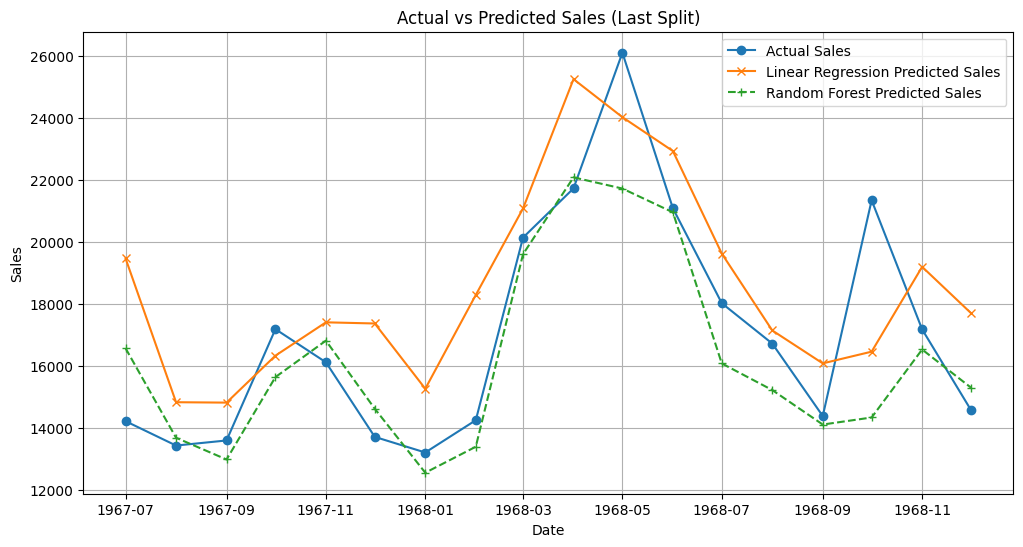

In [8]:
# Print average results
print("\nLinear Regression Evaluation (Cross-Validation):")
print(f"Mean MAE: {np.mean(mae_lr_scores):.2f}")
print(f"Mean RMSE: {np.mean(rmse_lr_scores):.2f}")

print("\nRandom Forest Evaluation (Cross-Validation):")
print(f"Mean MAE: {np.mean(mae_rf_scores):.2f}")
print(f"Mean RMSE: {np.mean(rmse_rf_scores):.2f}")

# Plot the results for the last split
plt.figure(figsize=(12, 6))
plt.plot(data.index[test_index], y_test, label='Actual Sales', marker='o')
plt.plot(data.index[test_index], y_pred_lr, label='Linear Regression Predicted Sales', marker='x')
plt.plot(data.index[test_index], y_pred_rf, label='Random Forest Predicted Sales', marker='+', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (Last Split)')
plt.legend()
plt.grid(True)
plt.show()

# F. 6. Model Deployment (Simplified Example)
# In a real deployment, you would use a framework like Flask, FastAPI, or cloud services.

In [9]:
import pickle

# Model Serialization (Save the models)
# Select the best model based on cross-validation results and save that
# In this case, we are saving the model from the last split but in a real application, the best model should be retrained on all the data.
filename_lr = 'linear_regression_model.pkl'
filename_rf = 'random_forest_model.pkl'

pickle.dump(model_lr, open(filename_lr, 'wb'))
pickle.dump(model_rf, open(filename_rf, 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb')) #Save the scaler from the LAST split. For prod, retrain on all data then pickle

# Example of loading the model and making a prediction
loaded_model_lr = pickle.load(open(filename_lr, 'rb'))
loaded_model_rf = pickle.load(open(filename_rf, 'rb'))
loaded_scaler = pickle.load(open('scaler.pkl', 'rb'))

# Example input (replace with your actual input data)
# This input must be pre-processed exactly like the training data
# It needs the same features, and the same scaling
last_date = data.index[-1]
next_month = last_date + pd.DateOffset(months=1)
input_data = pd.DataFrame({
    'Year': [next_month.year],
    'Month_Num': [next_month.month],
    'Quarter': [next_month.quarter],
    'Month_sin': [np.sin(2 * np.pi * next_month.month / 12)],
    'Month_cos': [np.cos(2 * np.pi * next_month.month / 12)],
    'Sales_Lag_1': [data['Sales'].iloc[-1]],
    'Sales_Lag_2': [data['Sales'].iloc[-2]],
    'Sales_Rolling_Mean': [data['Sales_Rolling_Mean'].iloc[-1]], #Rolling mean needs previous sales data

})

# Ensure the order of columns is the same as during training
input_data = input_data[features] #Reorder columns

#Scale the input data
input_scaled = loaded_scaler.transform(input_data)

# Make a prediction
prediction_lr = loaded_model_lr.predict(input_scaled)
prediction_rf = loaded_model_rf.predict(input_scaled)

print("\nExample Prediction for next month using Linear Regression:", prediction_lr[0])
print("\nExample Prediction for next month using Random Forest:", prediction_rf[0])

# Placeholder for the actual model API.
# Replace with Flask/FastAPI or similar.
# Example:
# @app.route('/predict', methods=['POST'])
# def predict():
#     data = request.get_json(force=True)
#     # Process data, make prediction using the loaded model, and return result

# --- G. 7. Monitoring & Alerting and Retraining Strategy are conceptual here ---
# Monitoring: Track forecast accuracy over time.  Implement data drift detection.
# Alerting:  Set up alerts for significant drops in accuracy or data drift.
# Retraining:  Retrain the model periodically (e.g., monthly) or when triggered by alerts.

# --- H. 8. Stakeholder Communication ---
# Report forecasts to the sales manager and inventory planner, along with uncertainty intervals.  Explain forecast deviations.


Example Prediction for next month using Linear Regression: 15978.319171802188

Example Prediction for next month using Random Forest: 12385.26
